In [1]:
# pip install duckdb
# pip install jupysql
# pip install notebook
# pip install tabulate
# pip install sqlalchemy

In [2]:
# If on windows, this only works if you're running Jupyter as an admin
# pip install duckdb-engine

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import sqlalchemy
from datetime import date
import json
import pathlib
# import importlib
%load_ext sql

In [2]:
# Set up SQL connection
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Change the billboard_observation_date!

In [3]:
current_date = date.today().strftime('%Y-%m-%d')
billboard_observation_date = '2024-04-02'

In [4]:
# Replace with your filepath. Forward slashes work for both Mac and Windows
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

In [5]:
# Test connection
%sql USE raw_db;
%sql USE raw_db.billboard;

,Success


# Update upload/rank_by_name

In [6]:
# Update this for this week's rankings in upload/rank_by_name.py
# This is easier in an IDE that allows opt+arrow_key to move lines up and down

In [7]:
# TODO: figure out importlib.reload() here so I don't have to kill the kernel to reload
# from upload.rank_by_name import rankings
from upload.backfill_rank_by_name import rankings

if len(rankings) != 50:
    print(f'{len(rankings)} rankings, but expected 50')

rankings[:5] + ['...'] + rankings[45:]

["Texas Hold 'Em",
 'I Remember Everything',
 'Fast Car',
 'Last Night',
 "Thinkin' Bout Me",
 '...',
 'The Architect',
 'Nine Ball',
 'Chevrolet',
 'Damn Near Normal',
 '28th Of June']

In [8]:
%%sql df_song_labeled <<
SELECT
    ss.song_id
    , ss.song_name
    , art.artist_name
    , s2a.relationship_type
    , ss.untracked_weeks_on_chart
FROM song ss
LEFT JOIN song_to_artist s2a
    ON ss.song_id = s2a.song_id
LEFT JOIN artist art
    ON s2a.artist_id = art.artist_id
;

In [9]:
existing_song_to_rank = {}
new_song_to_rank = {}
for song, rank_ix in zip(rankings, range(1,51)):
    n_rows = df_song_labeled[df_song_labeled['song_name'] == song]['song_id'].count()
    if n_rows == 0:
        new_song_to_rank[song] = rank_ix
    else:
        print(df_song_labeled.loc[df_song_labeled['song_name'] == song].to_markdown())
        song_id = input("Please enter the song_id or 'New Song'\n")

        if song_id == '': # hit enter to take the most common song ID
            song_id = int(
                df_song_labeled.loc[
                    df_song_labeled['song_name'] == song
                ]['song_id'].mode()
            )
        
        if str(song_id).lower() == 'new song':
            new_song_to_rank[song] = rank_ix
        else:
            existing_song_to_rank[int(song_id)] = rank_ix

|    |   song_id | song_name      | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:---------------|:--------------|:--------------------|---------------------------:|
| 93 |       116 | Texas Hold 'Em | Beyonce       | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name             | artist_name     | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:----------------------|:----------------|:--------------------|---------------------------:|
|   0 |         1 | I Remember Everything | Kacey Musgraves | Featured artist     |                         21 |
| 141 |         1 | I Remember Everything | Zach Bryan      | Lead artist         |                         21 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name   | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:------------|:--------------|:--------

Please enter the song_id or 'New Song'

|     |   song_id | song_name              | artist_name     | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:-----------------------|:----------------|:--------------------|---------------------------:|
|  94 |       117 | We Don't Fight Anymore | Chris Stapleton | Featured artist     |                         22 |
| 176 |       117 | We Don't Fight Anymore | Carly Pearce    | Lead artist         |                         22 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name   | artist_name      | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:------------|:-----------------|:--------------------|---------------------------:|
| 12 |        26 | Holy Smokes | Bailey Zimmerman | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name     | artist_name     | relationship_type   |   untracked_weeks_on_chart |
|----:|---

In [10]:
# Notes
# s2a for Fast Car (already +43)
# s2a for Last Night (already +51)
# s2a for Thinkin' Bout Me
# Truck Bed

In [10]:
# Check that you have 50 songs
print(len(existing_song_to_rank), '+')
print(list(new_song_to_rank.keys()))

44 +
['23', "Mamaw's House", 'Too Good To Be True', 'Tie Up', 'The Architect', '28th Of June']


### Add artists on any new songs that aren't in the artist table yet to its CSV

In [11]:
df_artist = pd.read_csv('source_data/artist.csv')

23: Chayce Beckham(87) +35
Mamaw's House: Thomas Rhett(22) feat Morgan Wallen(2) +16
Too Good To Be True: Kacey Musgraves(30)
Tie Up: Zac Brown Band(28)
The Architect: Kacey Musgraves(30)
28th Of June: Megan Moroney(4)

[s2a only]
Fast Car: Luke Combs(6)
Last Night: Morgan Wallen(2)
Thinkin' Bout Me: Morgan Wallen(2)
Truck Bed: HARDY(58)

In [12]:
new_song_artists = [
    'Chayce Beckham'
    , 'Thomas Rhett'
    , 'Morgan Wallen'
    , 'Kacey Musgraves'
    , 'Zac Brown Band'
    , 'Megan Moroney'
    , 'Luke Combs'
    , 'HARDY'
]
df_artist[df_artist['artist_name'].isin(new_song_artists)]

,artist_id,artist_name,pct_female,last_update
1,2,Morgan Wallen,0.000000,2024-08-23
3,4,Megan Moroney,1.000000,2024-08-23
5,6,Luke Combs,0.000000,2024-08-23
21,22,Thomas Rhett,0.000000,2024-08-23
27,28,Zac Brown Band,0.111111,2024-08-23
29,30,Kacey Musgraves,1.000000,2024-08-23
57,58,HARDY,0.000000,2024-08-29


In [13]:
df_artist['artist_id'].max()

86

In [14]:
df_artist = pd.concat(
    [
        df_artist
        , pd.DataFrame(
            np.array([
                [87, 'Chayce Beckham', 0, current_date]
            ])
            , columns = ['artist_id', 'artist_name', 'pct_female', 'last_update']
        )
    ]
    , ignore_index = True
)

In [15]:
df_artist.to_csv('source_data/artist.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2024-04-02


### Add all new songs to the song table CSV

In [16]:
df_song_raw = pd.read_csv('source_data/song.csv')

In [17]:
max_song_id = df_song_raw['song_id'].max()
array_new_songs = []
for song_name in list(new_song_to_rank.keys()):
    max_song_id += 1
    array_new_songs += [[max_song_id, song_name, 0, current_date]]

array_new_songs

[[167, '23', 0, '2024-09-16'],
 [168, "Mamaw's House", 0, '2024-09-16'],
 [169, 'Too Good To Be True', 0, '2024-09-16'],
 [170, 'Tie Up', 0, '2024-09-16'],
 [171, 'The Architect', 0, '2024-09-16'],
 [172, '28th Of June', 0, '2024-09-16']]

In [18]:
df_song_raw = pd.concat(
    [
        df_song_raw
        , pd.DataFrame(
            np.array(array_new_songs)
            , columns = ['song_id', 'song_name', 'untracked_weeks_on_chart', 'last_update']
        )
    ]
    , ignore_index = True
)
df_song_raw[-len(array_new_songs)-1:]

,song_id,song_name,untracked_weeks_on_chart,last_update
165,166,Amen,0.0,2024-09-16
166,167,23,0,2024-09-16
167,168,Mamaw's House,0,2024-09-16
168,169,Too Good To Be True,0,2024-09-16
169,170,Tie Up,0,2024-09-16
170,171,The Architect,0,2024-09-16
171,172,28th Of June,0,2024-09-16


23: Chayce Beckham(87) +35
Mamaw's House: Thomas Rhett(22) feat Morgan Wallen(2) +16
Too Good To Be True: Kacey Musgraves(30)
Tie Up: Zac Brown Band(28)
The Architect: Kacey Musgraves(30)
28th Of June: Megan Moroney(4)

[s2a only]
Fast Car: Luke Combs(6)
Last Night: Morgan Wallen(2)
Thinkin' Bout Me: Morgan Wallen(2)
Truck Bed: HARDY(58)

In [19]:
# Adjust untracked weeks if they aren't zero
for song_id, untracked_weeks in [
    (167, 35)
    , (168, 16)
]:
    df_song_raw.loc[
        df_song_raw['song_id'] == str(song_id)
        , 'untracked_weeks_on_chart'
    ] = untracked_weeks

In [20]:
df_song_raw[df_song_raw['song_name'].isin([
    'Fast Car'
    , 'Last Night'
    , "Thinkin' Bout Me"
    , 'Truck Bed'
])]

,song_id,song_name,untracked_weeks_on_chart,last_update
1,2,Last Night,51.0,2024-8-23
2,3,Thinkin' Bout Me,46.0,2024-8-23
3,4,Fast Car,43.0,2024-8-23
10,11,Truck Bed,42.0,2024-8-23


In [21]:
df_song_raw[-len(array_new_songs)-1:]

,song_id,song_name,untracked_weeks_on_chart,last_update
165,166,Amen,0.0,2024-09-16
166,167,23,35,2024-09-16
167,168,Mamaw's House,16,2024-09-16
168,169,Too Good To Be True,0,2024-09-16
169,170,Tie Up,0,2024-09-16
170,171,The Architect,0,2024-09-16
171,172,28th Of June,0,2024-09-16


In [22]:
df_song_raw.to_csv('source_data/song.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2024-04-02


#### Add all new songs to the song_to_artist table CSV

In [23]:
df_s2a_raw = pd.read_csv('source_data/song_to_artist.csv').fillna('')

23: Chayce Beckham(87) +35
Mamaw's House: Thomas Rhett(22) feat Morgan Wallen(2) +16
Too Good To Be True: Kacey Musgraves(30)
Tie Up: Zac Brown Band(28)
The Architect: Kacey Musgraves(30)
28th Of June: Megan Moroney(4)

[s2a only]
Fast Car: Luke Combs(6)
Last Night: Morgan Wallen(2)
Thinkin' Bout Me: Morgan Wallen(2)
Truck Bed: HARDY(58)

In [24]:
array_new_s2a = []
for s2a in [ # song_id, artist_id, relationship_conjunction, relationship_index
    [167, 87, '', '']
    , [168, 22, '', '']
    , [168, 2, '', 1]
    , [169, 30, '', '']
    , [170, 28, '', '']
    , [171, 30, '', '']
    , [172, 4, '', '']
    , [4, 6, '', '']
    , [2, 2, '', '']
    , [3, 2, '', '']
    , [11, 58, '', '']
]:
    if s2a[3] == '': # Only lead artists don't have a relationship index
        reln = 'Lead artist'
    elif s2a[2] == '': # Featured artists don't have an explicit relationship conjunction
        reln = 'Featured artist' 
    else:
        reln = 'Other main artist'
        
    array_new_s2a += [[
        '-'.join([str(s2a[0]), reln, str(s2a[3])])
        , s2a[0]
        , s2a[1]
        , reln
        , s2a[2]
        , s2a[3]
        , current_date
    ]]
    
array_new_s2a

[['167-Lead artist-', 167, 87, 'Lead artist', '', '', '2024-09-16'],
 ['168-Lead artist-', 168, 22, 'Lead artist', '', '', '2024-09-16'],
 ['168-Featured artist-1', 168, 2, 'Featured artist', '', 1, '2024-09-16'],
 ['169-Lead artist-', 169, 30, 'Lead artist', '', '', '2024-09-16'],
 ['170-Lead artist-', 170, 28, 'Lead artist', '', '', '2024-09-16'],
 ['171-Lead artist-', 171, 30, 'Lead artist', '', '', '2024-09-16'],
 ['172-Lead artist-', 172, 4, 'Lead artist', '', '', '2024-09-16'],
 ['4-Lead artist-', 4, 6, 'Lead artist', '', '', '2024-09-16'],
 ['2-Lead artist-', 2, 2, 'Lead artist', '', '', '2024-09-16'],
 ['3-Lead artist-', 3, 2, 'Lead artist', '', '', '2024-09-16'],
 ['11-Lead artist-', 11, 58, 'Lead artist', '', '', '2024-09-16']]

In [25]:
df_s2a_raw = pd.concat(
    [
        df_s2a_raw
        , pd.DataFrame(
            np.array(array_new_s2a)
            , columns = [
                'song_to_artist_pk'
                , 'song_id'
                , 'artist_id'
                , 'relationship_type'
                , 'relationship_conjunction'
                , 'relationship_index'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
)
df_s2a_raw.tail(1)

,song_to_artist_pk,song_id,artist_id,relationship_type,relationship_conjunction,relationship_index,last_update
212,11-Lead artist-,11,58,Lead artist,,,2024-09-16


In [26]:
df_s2a_raw.to_csv('source_data/song_to_artist.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2024-04-02


#### Convert new_song_to_rank to the id_to_rankix format of existing_song_to_rank
Then stack the two dicts of songs and insert to CSV with more info like current_date for last_update

In [27]:
all_song_to_rank = existing_song_to_rank.copy()
for song_name, rank in new_song_to_rank.items():
    songs = list(df_song_raw[df_song_raw['song_name'] == song_name]['song_id'])
    
    if len(songs) == 1:
        song_id = songs[0]
    elif len(songs) > 1:
        song_id = int(input(f'{str(songs)}: Choose ID of song actually at rank {rank}\n'))
    else:
        raise Exception(f'The song at rank {rank} is missing from the song CSV')
    
    all_song_to_rank[int(song_id)] = rank

array_new_ranking = [
    [
        '-'.join([billboard_observation_date, str(rank)])
        , billboard_observation_date
        , rank
        , song_id
        , current_date
    ]
    for song_id, rank
    in all_song_to_rank.items()
]

array_new_ranking[45:] # should be 5 rows, new songs come at end

[['2024-04-02-14', '2024-04-02', 14, 168, '2024-09-16'],
 ['2024-04-02-39', '2024-04-02', 39, 169, '2024-09-16'],
 ['2024-04-02-43', '2024-04-02', 43, 170, '2024-09-16'],
 ['2024-04-02-46', '2024-04-02', 46, 171, '2024-09-16'],
 ['2024-04-02-50', '2024-04-02', 50, 172, '2024-09-16']]

In [28]:
pd.concat(
    [
        pd.read_csv('source_data/billboard_ranking.csv').fillna('')
        , pd.DataFrame(
            np.array(array_new_ranking)
            , columns = [
                'billboard_ranking_pk'
                , 'billboard_observation_date'
                , 'billboard_rank'
                , 'song_id'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
).to_csv('source_data/billboard_ranking.csv', index=False)

print('Done for', billboard_observation_date)

Done for 2024-04-02


## Push to duckdb

In [29]:
# TODO: instead of purging and rebuilding, use the raw data to run updates
%sql --close duckdb:///C:/Users/Admin/billboard/raw_db.duckdb --quiet
pathlib.Path('raw_db.duckdb').unlink(missing_ok = True)

TODO: integrate into jupyter using `%python`

In a command terminal
- `python table_configs/run_schema_configs.py billboard_schema.sql`
- `python table_configs/run_table_configs.py`
- `python main.py`

In [30]:
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

## Run the ranking SQL script

In [31]:
weeks_lookback = 13 # Arbitrary lookback

with duckdb.connect('raw_db.duckdb') as conn:
    for weeks_ago in range(weeks_lookback):
        if weeks_ago == 0:
            with open('analysis/artist_ranking.sql') as sql_file:
                artist_ranking = conn.sql(sql_file.read().format(weeks_ago = str(weeks_ago)))
                df_artist_ranking = pd.DataFrame(
                    data=artist_ranking.fetchall()
                    , columns=artist_ranking.columns
                )

        else: # Have to close and reopen file between executions for fetchall() to work
            with open('analysis/artist_ranking.sql') as sql_file:
                prev_artist_ranking = conn.sql(sql_file.read().format(weeks_ago = str(weeks_ago)))
                df_artist_ranking = pd.concat([
                    df_artist_ranking
                    , pd.DataFrame(
                        data=prev_artist_ranking.fetchall()
                        , columns=artist_ranking.columns
                    )
                ])

In [49]:
# TODO make this show NA() for lookback windows with zero artist song credits
df_artist_ranking_over_time = df_artist_ranking.pivot(
    index = 'artist_name'
    , columns = 'weeks_ago'
    , values = 'artist_rank'
).sort_values(0)

df_artist_ranking_over_time.loc[:, -3:][:25]

weeks_ago,-3,-2,-1,0
artist_name,,,,
Zach Bryan,1,1,1,1
Post Malone,10,5,4,2
Morgan Wallen,3,3,3,3
Beyonce,2,2,2,4
Megan Moroney,4,4,5,5
Jelly Roll,5,6,6,6
Luke Combs,6,7,7,7
Bailey Zimmerman,7,8,8,8
Tucker Wetmore,8,9,9,9


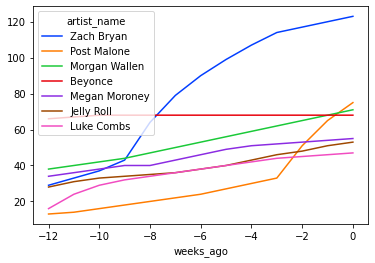

In [33]:
graph = sns.lineplot(
    data = df_artist_ranking.pivot(
        index = 'artist_name'
        , columns = 'weeks_ago'
        , values = 'recent_weeks_main_artist'
      ).loc[
        df_artist_ranking_over_time[0].keys() # maintain order from rank
      ][:7].fillna(np.inf).T
    , dashes = False
    #, markers = ['.'] * n_cols # TODO define new cols
    , palette = 'bright'
)
# title = 'Number of weeks as main artist'
# size = scale up plot size, then scale up number of lines

In [35]:
# Current artist rankings
pd.set_option('display.max_rows', 100)
cols = list(df_artist_ranking.columns)
col_nums = { col:ix for (col,ix) in zip(cols, range(len(cols))) }
df_artist_ranking_compact = df_artist_ranking.rename(columns = col_nums)
df_artist_ranking_compact.loc[ :, 1 : len(cols) - 2 ][df_artist_ranking['weeks_ago'] == 0]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Zach Bryan,0,123,123,123,162,162,162,22,22,22,22,22,22,2.0,2.0,2.0,2,2024-04-02
1,Post Malone,0,70,75,75,70,75,75,19,20,20,19,20,20,1.0,1.0,1.0,1,2024-04-09
2,Morgan Wallen,0,49,71,84,180,202,231,6,8,10,6,8,10,1.0,1.0,1.0,1,2024-04-02
3,Beyonce,0,68,68,68,68,68,68,16,16,16,16,16,16,1.0,1.0,1.0,1,2024-04-02
4,Megan Moroney,0,49,55,55,69,79,79,6,7,7,6,7,7,21.0,21.0,21.0,21,2024-04-02
5,Jelly Roll,0,34,53,78,36,70,96,5,7,9,5,7,9,7.0,7.0,7.0,7,2024-04-02
6,Luke Combs,0,47,47,55,138,138,146,10,10,12,11,11,13,3.0,3.0,3.0,3,2024-04-02
7,Bailey Zimmerman,0,41,41,41,47,47,47,4,4,4,4,4,4,6.0,6.0,6.0,6,2024-04-02
8,Tucker Wetmore,0,40,40,40,40,40,40,3,3,3,3,3,3,11.0,11.0,11.0,11,2024-04-02
9,Dylan Scott,0,26,39,39,34,53,53,2,3,3,2,3,3,35.0,35.0,35.0,35,2024-04-02


In [95]:
%%sql df_weeks_for_artist <<
SELECT
    br.billboard_observation_date
    , br.song_id
    , ss.song_name
    , br.billboard_rank
    , s2a.artist_id
    , art.artist_name
    , s2a.relationship_type
    , art.pct_female
FROM raw_db.billboard.billboard_ranking br
LEFT JOIN raw_db.billboard.song ss
    ON br.song_id = ss.song_id
LEFT JOIN raw_db.billboard.song_to_artist s2a
    ON br.song_id = s2a.song_id
LEFT JOIN raw_db.billboard.artist art
    ON s2a.artist_id = art.artist_id
ORDER BY 1 ASC

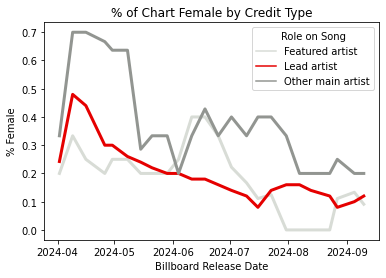

In [99]:
palette = {'Lead artist':"xkcd:red",
           'Other main artist':"xkcd:gray", 
           'Featured artist':'xkcd:light gray'}

sns.lineplot(
    data = df_weeks_for_artist.groupby(
        ['billboard_observation_date', 'relationship_type']
    ).mean()['pct_female'].reset_index()
    , x = 'billboard_observation_date'
    , y = 'pct_female'
    , hue = 'relationship_type'
    , palette = palette
    , linewidth = 3
).set(
    title = '% of Chart Female by Credit Type'
    , xlabel = 'Billboard Release Date' # Really observation date (for now)
    , ylabel = '% Female'
)

plt.legend(title = 'Role on Song')

plt.show()

In [60]:
# TODO enrich with n_songs from above
df_weeks_for_artist[
    df_weeks_for_artist['billboard_observation_date'] == billboard_observation_date
].groupby('artist_name').count().iloc[:,1].loc[
    lambda x: x > 1
].sort_values(ascending = False)

artist_name
Morgan Wallen      5
Kacey Musgraves    4
Megan Moroney      4
Jelly Roll         3
Chris Stapleton    2
Dylan Scott        2
Luke Combs         2
Zach Bryan         2
Name: song_id, dtype: int64

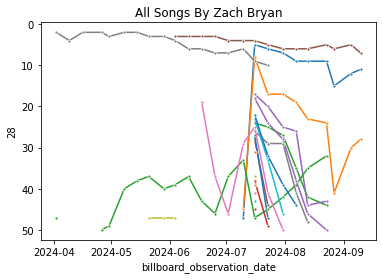

In [61]:
# For now, manual artist name selection
# TODO: Create charts for every artist on this week's chart at once
artist_name = 'Zach Bryan' # TODO: use artist ID, but label with artist_name

sns.color_palette('Paired') # TOFIX
for _, row in df_weeks_for_artist.query(
    f"artist_name == '{artist_name}'"
).pivot( # TODO no pivot to support legend in chart
    index = 'song_name'
    , columns = 'billboard_observation_date' #TODO: weeks ago
    , values = 'billboard_rank'
).fillna(np.inf).iterrows():
    graph = sns.lineplot(
        data = row
        , dashes = False
        , marker = '.'
    )
    
graph.set_title(f'All Songs By {artist_name}')
graph.axes.invert_yaxis()
# Force 0-50 axis and -25 to 0 on the weeks back

In [58]:
with duckdb.connect('raw_db.duckdb') as conn:
    print(conn.sql(
        """
        SELECT billboard_observation_date, COUNT(1) n
        FROM raw_db.billboard.billboard_ranking
        GROUP BY 1
        ORDER BY 1 DESC
        """
    ))

┌────────────────────────────┬───────┐
│ billboard_observation_date │   n   │
│            date            │ int64 │
├────────────────────────────┼───────┤
│ 2024-09-10                 │    50 │
│ 2024-09-05                 │    50 │
│ 2024-08-27                 │    50 │
│ 2024-08-23                 │    50 │
│ 2024-08-13                 │    50 │
│ 2024-08-07                 │    50 │
│ 2024-07-31                 │    50 │
│ 2024-07-23                 │    50 │
│ 2024-07-16                 │    50 │
│ 2024-07-10                 │    50 │
│ 2024-07-02                 │    50 │
│ 2024-06-25                 │    50 │
│ 2024-06-18                 │    50 │
│ 2024-06-11                 │    50 │
│ 2024-06-04                 │    50 │
│ 2024-05-29                 │    50 │
│ 2024-05-21                 │    50 │
│ 2024-05-15                 │    50 │
│ 2024-05-08                 │    50 │
│ 2024-04-30                 │    50 │
│ 2024-04-26                 │    50 │
│ 2024-04-16             

In [39]:
# TODO: Set comparison_observation_date as num weeks back, not specific date
current_observation_date = billboard_observation_date
comparison_observation_date = '2024-06-18' # TODO

with duckdb.connect('raw_db.duckdb') as conn:
    with open('analysis/removed_songs.sql') as sql_file:
        removed_songs = conn.sql(
            sql_file.read().format(
                current_observation_date
                , comparison_observation_date
            )
        )
    print(removed_songs)

┌─────────┬───────────────────────────┬────────────────┐
│ song_id │         song_name         │ ranking_before │
│  int32  │          varchar          │     int32      │
├─────────┼───────────────────────────┼────────────────┤
│      38 │ I Had Some Help           │              1 │
│      43 │ Pink Skies                │              3 │
│      37 │ Miles On It               │              7 │
│      47 │ High Road                 │              8 │
│      40 │ Ain't No Love In Oklahoma │              9 │
│      41 │ Sweet Dreams              │             10 │
│     109 │ The Man He Sees In Me     │             16 │
│      94 │ Purple Gas                │             19 │
│      39 │ Beautiful As You          │             26 │
│      42 │ Hang Tight Honey          │             27 │
│      48 │ I Am Not Okay             │             32 │
│      72 │ Indifferent               │             40 │
│      45 │ Wanna Be Loved            │             41 │
│      93 │ Boys Back Home     

# Scratch work to get song sparklines

In [ ]:
# TODO consider adding a measurement start date column
    # for Friday of each week based on observation date

In [46]:
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

In [47]:
%%sql df_weeks <<
SELECT
    br.billboard_observation_date
    , br.song_id
    , ss.song_name
    , br.billboard_rank
FROM raw_db.billboard.billboard_ranking br
LEFT JOIN raw_db.billboard.song ss
    ON br.song_id = ss.song_id
ORDER BY 1 ASC

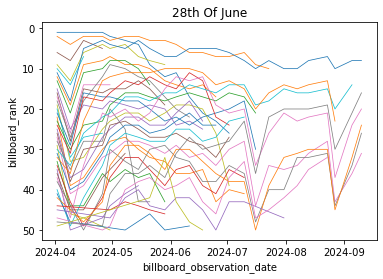

In [48]:
for _, row in df_weeks.query(
    # f"billboard_observation_date == '2024-09-10'"
    f"billboard_observation_date == '{billboard_observation_date}'"
).sort_values('billboard_rank').iterrows():
    this_song = df_weeks[
        df_weeks['song_id'] == row['song_id']
    ].sort_values('billboard_observation_date').fillna(np.inf)
    
    graph = sns.lineplot(
        data = this_song
        , x = 'billboard_observation_date' # TODO: weeks back instead of obs date
        , y = 'billboard_rank'
        # , marker = '.' # TODO: add back with bigger chart
        , dashes = False
        , linewidth = 0.75
        # , hue='k' # Not working with error 'cannot be assigned with wide-form data'
    ).set_title(this_song.reset_index()['song_name'][0])
    
graph.axes.invert_yaxis()
# TODO: verticalize x-axis labels
# TODO: Make this about 4x bigger

In [112]:
# TODO maybe: Each song on its own tile, rather than overlapped